First Step on Deep Learning Using Tensorflow
=============


各位同学们，我们在第九课上已经给大家介绍过了基础的深度学习知识。 这种最简单的网络是上一层网络全部链接到下一层网络，所以也称作 fully-connected（全连接） 网络。 

在本次作业中，我们将使用经典数据集 mnist的升级版，notMNIST构建神经网络进行图像分类。 

本次作业，你需要完成1, 2, 3三个联系。 能够掌握：

1. 数据预处理的知识
2. 深度学习程序的构建方式
3. 训练集、测试集、验证集
4. 神经网络的基础知识
5. 图计算网络
6. 正则化

等非常重要的知识 

Assignment 1
------------

The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later.

This notebook uses the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset to be used with python experiments. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

In [3]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labeled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [4]:
url = 'https://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = '/Users/zhangjie/Documents/machinelearning/att/nplAssignments-local/assigmnent09/assignment-09' # Change me to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = os.path.join(data_root, filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified /Users/zhangjie/Documents/machinelearning/att/nplAssignments-local/assigmnent09/assignment-09/notMNIST_large.tar.gz
Found and verified /Users/zhangjie/Documents/machinelearning/att/nplAssignments-local/assigmnent09/assignment-09/notMNIST_small.tar.gz


In [5]:
os.path.splitext(os.path.splitext(train_filename)[0])[0]

'/Users/zhangjie/Documents/machinelearning/att/nplAssignments-local/assigmnent09/assignment-09/notMNIST_large'

Extract the dataset from the compressed .tar.gz file.
This should give you a set of directories, labeled A through J.

In [6]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(data_root)
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

/Users/zhangjie/Documents/machinelearning/att/nplAssignments-local/assigmnent09/assignment-09/notMNIST_large already present - Skipping extraction of /Users/zhangjie/Documents/machinelearning/att/nplAssignments-local/assigmnent09/assignment-09/notMNIST_large.tar.gz.
['/Users/zhangjie/Documents/machinelearning/att/nplAssignments-local/assigmnent09/assignment-09/notMNIST_large/A', '/Users/zhangjie/Documents/machinelearning/att/nplAssignments-local/assigmnent09/assignment-09/notMNIST_large/B', '/Users/zhangjie/Documents/machinelearning/att/nplAssignments-local/assigmnent09/assignment-09/notMNIST_large/C', '/Users/zhangjie/Documents/machinelearning/att/nplAssignments-local/assigmnent09/assignment-09/notMNIST_large/D', '/Users/zhangjie/Documents/machinelearning/att/nplAssignments-local/assigmnent09/assignment-09/notMNIST_large/E', '/Users/zhangjie/Documents/machinelearning/att/nplAssignments-local/assigmnent09/assignment-09/notMNIST_large/F', '/Users/zhangjie/Documents/machinelearning/att/n

---
Problem 1
---------

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

---

Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. 

A few images might not be readable, we'll just skip them.

In [31]:
fn=os.listdir('/Users/zhangjie/Documents/machinelearning/att/nplAssignments-local/assigmnent09/assignment-09/notMNIST_small/A')
fn

['MDEtMDEtMDAudHRm.png',
 'MDRiXzA4LnR0Zg==.png',
 'MjAwcHJvb2Ztb29uc2hpbmUgcmVtaXgudHRm.png',
 'MlJlYmVsc0RldXgtQmxhY2sub3Rm.png',
 'MlRvb24gU2hhZG93LnR0Zg==.png',
 'MlRvb24yIFNoYWRvdy50dGY=.png',
 'MTAuMTUgU2F0dXJkYXkgTmlnaHQgQlJLLnR0Zg==.png',
 'MTFTMDEgQmxhY2sgVHVlc2RheSBPZmZzZXQudHRm.png',
 'MTggSG9sZXMgQlJLLnR0Zg==.png',
 'MTh0aENlbnR1cnkudHRm.png',
 'MTIgV2FsYmF1bSBJdGFsaWMgMTMyNjMudHRm.png',
 'MTJTYXJ1WWVsbG93Rm9nLnR0Zg==.png',
 'Nng3b2N0IEFsdGVybmF0ZSBFeHRyYUxpZ2h0LnR0Zg==.png',
 'Nng3b2N0IEFsdGVybmF0ZSBSZWd1bGFyLnR0Zg==.png',
 'NXRoR3JhZGVyLnR0Zg==.png',
 'OC1iaXQgTGltaXQgTyBCUksudHRm.png',
 'OEJhbGxTY3JpcHRTQ2Fwc1NTSyBJdGFsaWMudHRm.png',
 'OTExIFBvcnNjaGEgSXRhbGljLnR0Zg==.png',
 'OXNxZ3JkIFRoaW4udHRm.png',
 'Q09ERTNYLnR0Zg==.png',
 'Q0cgT21lZ2EudHRm.png',
 'Q0NDb21pY3JhenktQm9sZEl0YWxpYy50dGY=.png',
 'Q0NTcG9va3l0b290aC1SZWd1bGFyLnR0Zg==.png',
 'Q0NXaWxkV29yZHMtQm9sZEl0YWxpYy50dGY=.png',
 'Q0sgUGluay50dGY=.png',
 'Q1FOLU1vbGVjdWxhci1EeW5hbW8tUmVndWxhci5vdGY=.png',
 'Q290cmFu

In [10]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
    """Load the data for a single letter label."""
    image_files = os.listdir(folder)
    dataset = np.ndarray(shape=(len(image_files), image_size, image_size),dtype=np.float32)
    print(folder)
    num_images = 0
    for image in image_files:
        image_file = os.path.join(folder, image)
        try:
            image_data = (imageio.imread(image_file).astype(float) - pixel_depth / 2) / pixel_depth
            if image_data.shape != (image_size, image_size):
                raise Exception('Unexpected image shape: %s' % str(image_data.shape))
            dataset[num_images, :, :] = image_data
            num_images = num_images + 1
        except (IOError, ValueError) as e:
            print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
    dataset = dataset[0:num_images, :, :]
    if num_images < min_num_images:
        raise Exception('Many fewer images than expected: %d < %d' %(num_images, min_num_images))
    
    print('Full dataset tensor:', dataset.shape)
    print('Mean:', np.mean(dataset))
    print('Standard deviation:', np.std(dataset))
    return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
    dataset_names = []
    for folder in data_folders:
        set_filename = folder + '.pickle'
        dataset_names.append(set_filename)
        if os.path.exists(set_filename) and not force:
            # You may override by setting force=True.
            print('%s already present - Skipping pickling.' % set_filename)
        else:
            print('Pickling %s.' % set_filename)
            dataset = load_letter(folder, min_num_images_per_class)
            print('dataset.shape',dataset.shape)
            try:
                with open(set_filename, 'wb') as f:
                    pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
            except Exception as e:
                print('Unable to save data to', set_filename, ':', e)
    return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

/Users/zhangjie/Documents/machinelearning/att/nplAssignments-local/assigmnent09/assignment-09/notMNIST_large/A.pickle already present - Skipping pickling.
/Users/zhangjie/Documents/machinelearning/att/nplAssignments-local/assigmnent09/assignment-09/notMNIST_large/B.pickle already present - Skipping pickling.
/Users/zhangjie/Documents/machinelearning/att/nplAssignments-local/assigmnent09/assignment-09/notMNIST_large/C.pickle already present - Skipping pickling.
/Users/zhangjie/Documents/machinelearning/att/nplAssignments-local/assigmnent09/assignment-09/notMNIST_large/D.pickle already present - Skipping pickling.
/Users/zhangjie/Documents/machinelearning/att/nplAssignments-local/assigmnent09/assignment-09/notMNIST_large/E.pickle already present - Skipping pickling.
/Users/zhangjie/Documents/machinelearning/att/nplAssignments-local/assigmnent09/assignment-09/notMNIST_large/F.pickle already present - Skipping pickling.
/Users/zhangjie/Documents/machinelearning/att/nplAssignments-local/ass

In [11]:
print(train_datasets)

['/Users/zhangjie/Documents/machinelearning/att/nplAssignments-local/assigmnent09/assignment-09/notMNIST_large/A.pickle', '/Users/zhangjie/Documents/machinelearning/att/nplAssignments-local/assigmnent09/assignment-09/notMNIST_large/B.pickle', '/Users/zhangjie/Documents/machinelearning/att/nplAssignments-local/assigmnent09/assignment-09/notMNIST_large/C.pickle', '/Users/zhangjie/Documents/machinelearning/att/nplAssignments-local/assigmnent09/assignment-09/notMNIST_large/D.pickle', '/Users/zhangjie/Documents/machinelearning/att/nplAssignments-local/assigmnent09/assignment-09/notMNIST_large/E.pickle', '/Users/zhangjie/Documents/machinelearning/att/nplAssignments-local/assigmnent09/assignment-09/notMNIST_large/F.pickle', '/Users/zhangjie/Documents/machinelearning/att/nplAssignments-local/assigmnent09/assignment-09/notMNIST_large/G.pickle', '/Users/zhangjie/Documents/machinelearning/att/nplAssignments-local/assigmnent09/assignment-09/notMNIST_large/H.pickle', '/Users/zhangjie/Documents/mach

---
Problem 2
---------

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

---

(52909, 28, 28)


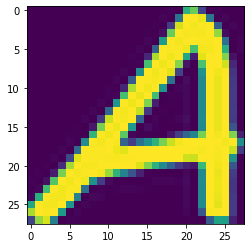

(52911, 28, 28)


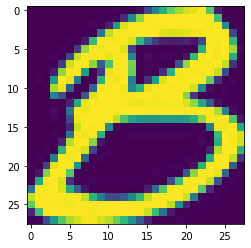

(52912, 28, 28)


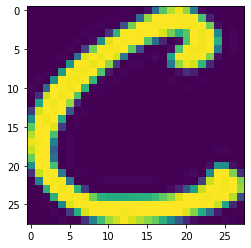

(52911, 28, 28)


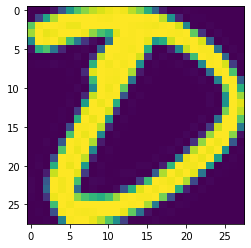

(52912, 28, 28)


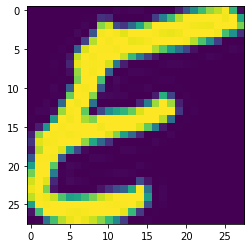

(52912, 28, 28)


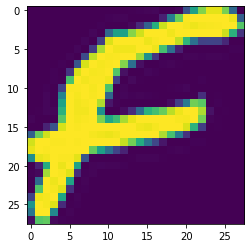

(52912, 28, 28)


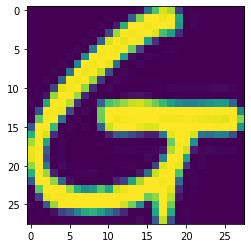

(52912, 28, 28)


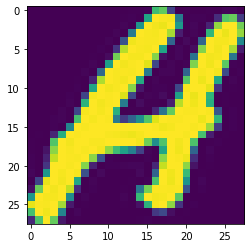

(52912, 28, 28)


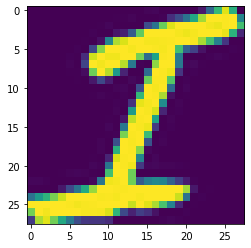

(52911, 28, 28)


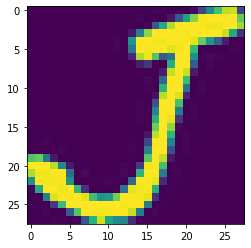

In [30]:
for train_dataset in train_datasets:
    with open (train_dataset,'rb') as pk_f:
        toshow=pickle.load(pk_f)
        print(toshow.shape)
        pic = toshow[80,:,:]
        plt.imshow(pic)
        plt.show()

---
Problem 3
---------
Another check: we expect the data to be balanced across classes. Verify that.

---

Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune `train_size` as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

In [21]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [22]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

---
Problem 4
---------
Convince yourself that the data is still good after shuffling!

---

Finally, let's save the data for later reuse:

In [23]:
pickle_file = os.path.join(data_root, 'notMNIST.pickle')

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [24]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800506


---
Problem 5
---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.

Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
---

In [25]:
def img_hash(pix_s):
    seed = 131
    v_hash = 0
    for row in pix_s:
        for p in row:
            v_hash = v_hash * seed + int(p * 255)
    return v_hash & 0x7FFFFFFF
def imgs_idx_hash_except(left, right):
    except_idxs = []
    right_hashes = [img_hash(img) for img in right]
    print(len(right_hashes))
    for i in range(len(left)):
        if img_hash(left[i]) in right_hashes:
            print('compare left[%d] to right found the same' % i)
            except_idxs.append(i)
    res = np.delete(left, except_idxs, axis=0)
    return except_idxs, res
def load_pickle(pickle_name):
    # load a pickle file to memory
    if os.path.exists(pickle_name):
        return pickle.load(open(pickle_name, "rb"))
    return None
def clean():
    datasets = load_pickle('/Users/zhangjie/Documents/machinelearning/att/nplAssignments-local/assigmnent09/assignment-09/notMNIST.pickle')
    test_dataset = datasets['test_dataset']
    test_labels = datasets['test_labels']
    print('test_dataset:%d' % len(test_dataset))
    print('test_labels:%d' % len(test_labels))

    except_valid_idx, valid_dataset = imgs_idx_hash_except(datasets['valid_dataset'], test_dataset)
    valid_labels = np.delete(datasets['valid_labels'], except_valid_idx)
    print('valid_dataset:%d' % len(valid_dataset))
    print('valid_labels:%d' % len(valid_labels))

    # except with valid_dataset
    except_train_idx, train_dataset = imgs_idx_hash_except(datasets['train_dataset'], valid_dataset)
    train_labels = np.delete(datasets['train_labels'], except_train_idx)
    # except with test_dataset
    except_train_idx, train_dataset = imgs_idx_hash_except(train_dataset, test_dataset)
    train_labels = np.delete(train_labels, except_train_idx)

    print('train_dataset:%d' % len(train_dataset))
    print('train_labels:%d' % len(train_labels))
    print('valid_dataset:%d' % len(valid_dataset))
    print('valid_labels:%d' % len(valid_labels))
    print('test_dataset:%d' % len(test_dataset))
    print('test_labels:%d' % len(test_labels))

    pickle_file = '/Users/zhangjie/Documents/machinelearning/att/nplAssignments-local/assigmnent09/assignment-09/notMNIST_clean.pickle'
    save = {
        'train_dataset': train_dataset,
        'train_labels': train_labels,
        'valid_dataset': valid_dataset,
        'valid_labels': valid_labels,
        'test_dataset': test_dataset,
        'test_labels': test_labels,
    }
    save_obj(pickle_file, save)
clean()

test_dataset:10000
test_labels:10000
10000
compare left[58] to right found the same
compare left[100] to right found the same
compare left[115] to right found the same
compare left[176] to right found the same
compare left[204] to right found the same
compare left[223] to right found the same
compare left[356] to right found the same
compare left[382] to right found the same
compare left[451] to right found the same
compare left[542] to right found the same
compare left[607] to right found the same
compare left[694] to right found the same
compare left[784] to right found the same
compare left[843] to right found the same
compare left[959] to right found the same
compare left[983] to right found the same
compare left[1100] to right found the same
compare left[1161] to right found the same
compare left[1228] to right found the same
compare left[1298] to right found the same
compare left[1317] to right found the same
compare left[1466] to right found the same
compare left[1537] to right 

compare left[6122] to right found the same
compare left[6181] to right found the same
compare left[6235] to right found the same
compare left[6788] to right found the same
compare left[6850] to right found the same
compare left[6945] to right found the same
compare left[7050] to right found the same
compare left[7063] to right found the same
compare left[7149] to right found the same
compare left[7267] to right found the same
compare left[7390] to right found the same
compare left[7577] to right found the same
compare left[7994] to right found the same
compare left[7995] to right found the same
compare left[8046] to right found the same
compare left[8088] to right found the same
compare left[8336] to right found the same
compare left[8444] to right found the same
compare left[8743] to right found the same
compare left[8821] to right found the same
compare left[9108] to right found the same
compare left[9270] to right found the same
compare left[9302] to right found the same
compare lef

compare left[33723] to right found the same
compare left[33894] to right found the same
compare left[34196] to right found the same
compare left[34520] to right found the same
compare left[34537] to right found the same
compare left[34706] to right found the same
compare left[34754] to right found the same
compare left[34914] to right found the same
compare left[34957] to right found the same
compare left[34963] to right found the same
compare left[35410] to right found the same
compare left[35427] to right found the same
compare left[35461] to right found the same
compare left[35589] to right found the same
compare left[35680] to right found the same
compare left[35722] to right found the same
compare left[35925] to right found the same
compare left[36111] to right found the same
compare left[36145] to right found the same
compare left[36264] to right found the same
compare left[36313] to right found the same
compare left[36460] to right found the same
compare left[36496] to right fou

compare left[59238] to right found the same
compare left[59425] to right found the same
compare left[59828] to right found the same
compare left[59932] to right found the same
compare left[60078] to right found the same
compare left[60132] to right found the same
compare left[60174] to right found the same
compare left[60374] to right found the same
compare left[60385] to right found the same
compare left[60676] to right found the same
compare left[60806] to right found the same
compare left[60807] to right found the same
compare left[61114] to right found the same
compare left[61147] to right found the same
compare left[61208] to right found the same
compare left[61227] to right found the same
compare left[61350] to right found the same
compare left[61496] to right found the same
compare left[61965] to right found the same
compare left[62017] to right found the same
compare left[62308] to right found the same
compare left[62428] to right found the same
compare left[62652] to right fou

compare left[84566] to right found the same
compare left[84583] to right found the same
compare left[84734] to right found the same
compare left[84900] to right found the same
compare left[85291] to right found the same
compare left[85363] to right found the same
compare left[85409] to right found the same
compare left[85591] to right found the same
compare left[85622] to right found the same
compare left[85675] to right found the same
compare left[85762] to right found the same
compare left[85850] to right found the same
compare left[85868] to right found the same
compare left[86218] to right found the same
compare left[86386] to right found the same
compare left[86746] to right found the same
compare left[86820] to right found the same
compare left[86968] to right found the same
compare left[87068] to right found the same
compare left[87165] to right found the same
compare left[87200] to right found the same
compare left[87260] to right found the same
compare left[87335] to right fou

compare left[111010] to right found the same
compare left[111078] to right found the same
compare left[111283] to right found the same
compare left[111287] to right found the same
compare left[111825] to right found the same
compare left[111969] to right found the same
compare left[112323] to right found the same
compare left[112552] to right found the same
compare left[112561] to right found the same
compare left[112565] to right found the same
compare left[112758] to right found the same
compare left[113218] to right found the same
compare left[113235] to right found the same
compare left[113464] to right found the same
compare left[113595] to right found the same
compare left[113662] to right found the same
compare left[113759] to right found the same
compare left[113775] to right found the same
compare left[113924] to right found the same
compare left[113940] to right found the same
compare left[113961] to right found the same
compare left[114041] to right found the same
compare le

compare left[137774] to right found the same
compare left[138042] to right found the same
compare left[138145] to right found the same
compare left[138690] to right found the same
compare left[138813] to right found the same
compare left[138817] to right found the same
compare left[138957] to right found the same
compare left[139037] to right found the same
compare left[139215] to right found the same
compare left[139345] to right found the same
compare left[139371] to right found the same
compare left[139460] to right found the same
compare left[139502] to right found the same
compare left[139515] to right found the same
compare left[139638] to right found the same
compare left[139669] to right found the same
compare left[139816] to right found the same
compare left[139883] to right found the same
compare left[140024] to right found the same
compare left[140069] to right found the same
compare left[140556] to right found the same
compare left[140654] to right found the same
compare le

compare left[164320] to right found the same
compare left[164508] to right found the same
compare left[164600] to right found the same
compare left[164618] to right found the same
compare left[164835] to right found the same
compare left[165084] to right found the same
compare left[165323] to right found the same
compare left[165344] to right found the same
compare left[165428] to right found the same
compare left[165895] to right found the same
compare left[166038] to right found the same
compare left[166233] to right found the same
compare left[166243] to right found the same
compare left[166251] to right found the same
compare left[166541] to right found the same
compare left[166722] to right found the same
compare left[166968] to right found the same
compare left[167468] to right found the same
compare left[167509] to right found the same
compare left[167821] to right found the same
compare left[167929] to right found the same
compare left[168031] to right found the same
compare le

compare left[195719] to right found the same
compare left[195996] to right found the same
compare left[196380] to right found the same
compare left[196503] to right found the same
compare left[196898] to right found the same
compare left[197259] to right found the same
compare left[197514] to right found the same
compare left[197571] to right found the same
compare left[197684] to right found the same
compare left[197845] to right found the same
compare left[197910] to right found the same
compare left[198230] to right found the same
compare left[198483] to right found the same
compare left[198496] to right found the same
compare left[198524] to right found the same
compare left[198733] to right found the same
compare left[198861] to right found the same
compare left[199100] to right found the same
compare left[199222] to right found the same
compare left[199231] to right found the same
compare left[199291] to right found the same
compare left[199361] to right found the same
compare le

compare left[8404] to right found the same
compare left[8408] to right found the same
compare left[8453] to right found the same
compare left[8454] to right found the same
compare left[8473] to right found the same
compare left[8521] to right found the same
compare left[8527] to right found the same
compare left[8535] to right found the same
compare left[8581] to right found the same
compare left[8663] to right found the same
compare left[8749] to right found the same
compare left[8816] to right found the same
compare left[8832] to right found the same
compare left[8864] to right found the same
compare left[8887] to right found the same
compare left[8895] to right found the same
compare left[8924] to right found the same
compare left[8926] to right found the same
compare left[8934] to right found the same
compare left[9103] to right found the same
compare left[9108] to right found the same
compare left[9113] to right found the same
compare left[9120] to right found the same
compare lef

compare left[18434] to right found the same
compare left[18439] to right found the same
compare left[18489] to right found the same
compare left[18492] to right found the same
compare left[18541] to right found the same
compare left[18545] to right found the same
compare left[18614] to right found the same
compare left[18699] to right found the same
compare left[18812] to right found the same
compare left[18821] to right found the same
compare left[18952] to right found the same
compare left[18967] to right found the same
compare left[19044] to right found the same
compare left[19084] to right found the same
compare left[19090] to right found the same
compare left[19199] to right found the same
compare left[19224] to right found the same
compare left[19227] to right found the same
compare left[19262] to right found the same
compare left[19276] to right found the same
compare left[19282] to right found the same
compare left[19291] to right found the same
compare left[19347] to right fou

compare left[28644] to right found the same
compare left[28757] to right found the same
compare left[28911] to right found the same
compare left[28969] to right found the same
compare left[29032] to right found the same
compare left[29063] to right found the same
compare left[29135] to right found the same
compare left[29158] to right found the same
compare left[29206] to right found the same
compare left[29228] to right found the same
compare left[29306] to right found the same
compare left[29335] to right found the same
compare left[29379] to right found the same
compare left[29436] to right found the same
compare left[29480] to right found the same
compare left[29604] to right found the same
compare left[29634] to right found the same
compare left[29665] to right found the same
compare left[29790] to right found the same
compare left[29813] to right found the same
compare left[29816] to right found the same
compare left[29818] to right found the same
compare left[29829] to right fou

compare left[38687] to right found the same
compare left[38827] to right found the same
compare left[38901] to right found the same
compare left[38912] to right found the same
compare left[39042] to right found the same
compare left[39112] to right found the same
compare left[39190] to right found the same
compare left[39255] to right found the same
compare left[39293] to right found the same
compare left[39381] to right found the same
compare left[39473] to right found the same
compare left[39480] to right found the same
compare left[39494] to right found the same
compare left[39583] to right found the same
compare left[39619] to right found the same
compare left[39818] to right found the same
compare left[39863] to right found the same
compare left[39865] to right found the same
compare left[39957] to right found the same
compare left[40100] to right found the same
compare left[40127] to right found the same
compare left[40183] to right found the same
compare left[40301] to right fou

compare left[50041] to right found the same
compare left[50153] to right found the same
compare left[50176] to right found the same
compare left[50181] to right found the same
compare left[50300] to right found the same
compare left[50360] to right found the same
compare left[50460] to right found the same
compare left[50471] to right found the same
compare left[50570] to right found the same
compare left[50795] to right found the same
compare left[50797] to right found the same
compare left[50828] to right found the same
compare left[50857] to right found the same
compare left[50901] to right found the same
compare left[50910] to right found the same
compare left[51024] to right found the same
compare left[51198] to right found the same
compare left[51214] to right found the same
compare left[51256] to right found the same
compare left[51311] to right found the same
compare left[51325] to right found the same
compare left[51335] to right found the same
compare left[51345] to right fou

compare left[60395] to right found the same
compare left[60433] to right found the same
compare left[60614] to right found the same
compare left[60645] to right found the same
compare left[60688] to right found the same
compare left[60777] to right found the same
compare left[60891] to right found the same
compare left[60949] to right found the same
compare left[61012] to right found the same
compare left[61065] to right found the same
compare left[61240] to right found the same
compare left[61344] to right found the same
compare left[61349] to right found the same
compare left[61409] to right found the same
compare left[61462] to right found the same
compare left[61529] to right found the same
compare left[61624] to right found the same
compare left[61709] to right found the same
compare left[61741] to right found the same
compare left[61808] to right found the same
compare left[61816] to right found the same
compare left[61881] to right found the same
compare left[61971] to right fou

compare left[71848] to right found the same
compare left[71871] to right found the same
compare left[71879] to right found the same
compare left[71894] to right found the same
compare left[71929] to right found the same
compare left[71935] to right found the same
compare left[71972] to right found the same
compare left[72008] to right found the same
compare left[72075] to right found the same
compare left[72180] to right found the same
compare left[72181] to right found the same
compare left[72208] to right found the same
compare left[72301] to right found the same
compare left[72314] to right found the same
compare left[72324] to right found the same
compare left[72354] to right found the same
compare left[72370] to right found the same
compare left[72391] to right found the same
compare left[72419] to right found the same
compare left[72428] to right found the same
compare left[72430] to right found the same
compare left[72438] to right found the same
compare left[72439] to right fou

compare left[80933] to right found the same
compare left[80953] to right found the same
compare left[80971] to right found the same
compare left[80976] to right found the same
compare left[81021] to right found the same
compare left[81055] to right found the same
compare left[81076] to right found the same
compare left[81081] to right found the same
compare left[81088] to right found the same
compare left[81125] to right found the same
compare left[81252] to right found the same
compare left[81264] to right found the same
compare left[81284] to right found the same
compare left[81312] to right found the same
compare left[81326] to right found the same
compare left[81328] to right found the same
compare left[81419] to right found the same
compare left[81459] to right found the same
compare left[81468] to right found the same
compare left[81483] to right found the same
compare left[81609] to right found the same
compare left[81674] to right found the same
compare left[81689] to right fou

compare left[90999] to right found the same
compare left[91046] to right found the same
compare left[91051] to right found the same
compare left[91071] to right found the same
compare left[91197] to right found the same
compare left[91222] to right found the same
compare left[91226] to right found the same
compare left[91329] to right found the same
compare left[91421] to right found the same
compare left[91539] to right found the same
compare left[91597] to right found the same
compare left[91683] to right found the same
compare left[91689] to right found the same
compare left[91744] to right found the same
compare left[91783] to right found the same
compare left[91802] to right found the same
compare left[91862] to right found the same
compare left[91880] to right found the same
compare left[91903] to right found the same
compare left[91943] to right found the same
compare left[91970] to right found the same
compare left[92007] to right found the same
compare left[92033] to right fou

compare left[102694] to right found the same
compare left[102703] to right found the same
compare left[102707] to right found the same
compare left[102801] to right found the same
compare left[102857] to right found the same
compare left[102895] to right found the same
compare left[102896] to right found the same
compare left[103025] to right found the same
compare left[103050] to right found the same
compare left[103088] to right found the same
compare left[103103] to right found the same
compare left[103120] to right found the same
compare left[103156] to right found the same
compare left[103198] to right found the same
compare left[103244] to right found the same
compare left[103246] to right found the same
compare left[103354] to right found the same
compare left[103381] to right found the same
compare left[103408] to right found the same
compare left[103445] to right found the same
compare left[103452] to right found the same
compare left[103556] to right found the same
compare le

compare left[112967] to right found the same
compare left[113029] to right found the same
compare left[113037] to right found the same
compare left[113196] to right found the same
compare left[113235] to right found the same
compare left[113249] to right found the same
compare left[113266] to right found the same
compare left[113460] to right found the same
compare left[113496] to right found the same
compare left[113544] to right found the same
compare left[113658] to right found the same
compare left[113758] to right found the same
compare left[113833] to right found the same
compare left[113901] to right found the same
compare left[114011] to right found the same
compare left[114032] to right found the same
compare left[114078] to right found the same
compare left[114089] to right found the same
compare left[114103] to right found the same
compare left[114114] to right found the same
compare left[114118] to right found the same
compare left[114122] to right found the same
compare le

compare left[123097] to right found the same
compare left[123109] to right found the same
compare left[123162] to right found the same
compare left[123198] to right found the same
compare left[123205] to right found the same
compare left[123234] to right found the same
compare left[123236] to right found the same
compare left[123238] to right found the same
compare left[123337] to right found the same
compare left[123414] to right found the same
compare left[123417] to right found the same
compare left[123454] to right found the same
compare left[123556] to right found the same
compare left[123677] to right found the same
compare left[123752] to right found the same
compare left[123815] to right found the same
compare left[123995] to right found the same
compare left[124030] to right found the same
compare left[124132] to right found the same
compare left[124224] to right found the same
compare left[124304] to right found the same
compare left[124328] to right found the same
compare le

compare left[132897] to right found the same
compare left[132908] to right found the same
compare left[132926] to right found the same
compare left[132948] to right found the same
compare left[133058] to right found the same
compare left[133121] to right found the same
compare left[133156] to right found the same
compare left[133159] to right found the same
compare left[133177] to right found the same
compare left[133344] to right found the same
compare left[133378] to right found the same
compare left[133390] to right found the same
compare left[133418] to right found the same
compare left[133480] to right found the same
compare left[133516] to right found the same
compare left[133567] to right found the same
compare left[133591] to right found the same
compare left[133603] to right found the same
compare left[133613] to right found the same
compare left[133773] to right found the same
compare left[133807] to right found the same
compare left[133967] to right found the same
compare le

compare left[142461] to right found the same
compare left[142531] to right found the same
compare left[142558] to right found the same
compare left[142589] to right found the same
compare left[142613] to right found the same
compare left[142656] to right found the same
compare left[142658] to right found the same
compare left[142696] to right found the same
compare left[142828] to right found the same
compare left[142884] to right found the same
compare left[143058] to right found the same
compare left[143081] to right found the same
compare left[143217] to right found the same
compare left[143220] to right found the same
compare left[143233] to right found the same
compare left[143255] to right found the same
compare left[143349] to right found the same
compare left[143444] to right found the same
compare left[143502] to right found the same
compare left[143503] to right found the same
compare left[143521] to right found the same
compare left[143545] to right found the same
compare le

compare left[153067] to right found the same
compare left[153208] to right found the same
compare left[153406] to right found the same
compare left[153433] to right found the same
compare left[153446] to right found the same
compare left[153473] to right found the same
compare left[153500] to right found the same
compare left[153522] to right found the same
compare left[153557] to right found the same
compare left[153558] to right found the same
compare left[153632] to right found the same
compare left[153641] to right found the same
compare left[153741] to right found the same
compare left[153755] to right found the same
compare left[153814] to right found the same
compare left[153841] to right found the same
compare left[153895] to right found the same
compare left[153979] to right found the same
compare left[153991] to right found the same
compare left[154207] to right found the same
compare left[154268] to right found the same
compare left[154325] to right found the same
compare le

compare left[162241] to right found the same
compare left[162277] to right found the same
compare left[162280] to right found the same
compare left[162312] to right found the same
compare left[162386] to right found the same
compare left[162415] to right found the same
compare left[162471] to right found the same
compare left[162575] to right found the same
compare left[162593] to right found the same
compare left[162672] to right found the same
compare left[162679] to right found the same
compare left[162837] to right found the same
compare left[162840] to right found the same
compare left[162880] to right found the same
compare left[163110] to right found the same
compare left[163152] to right found the same
compare left[163195] to right found the same
compare left[163414] to right found the same
compare left[163502] to right found the same
compare left[163528] to right found the same
compare left[163529] to right found the same
compare left[163701] to right found the same
compare le

compare left[172760] to right found the same
compare left[172814] to right found the same
compare left[172958] to right found the same
compare left[173070] to right found the same
compare left[173101] to right found the same
compare left[173169] to right found the same
compare left[173198] to right found the same
compare left[173228] to right found the same
compare left[173274] to right found the same
compare left[173293] to right found the same
compare left[173317] to right found the same
compare left[173329] to right found the same
compare left[173388] to right found the same
compare left[173473] to right found the same
compare left[173526] to right found the same
compare left[173708] to right found the same
compare left[173763] to right found the same
compare left[173869] to right found the same
compare left[173993] to right found the same
compare left[174077] to right found the same
compare left[174109] to right found the same
compare left[174136] to right found the same
compare le

compare left[181952] to right found the same
compare left[181998] to right found the same
compare left[182068] to right found the same
compare left[182196] to right found the same
compare left[182267] to right found the same
compare left[182280] to right found the same
compare left[182363] to right found the same
compare left[182373] to right found the same
compare left[182387] to right found the same
compare left[182395] to right found the same
compare left[182416] to right found the same
compare left[182452] to right found the same
compare left[182492] to right found the same
compare left[182573] to right found the same
compare left[182586] to right found the same
compare left[182683] to right found the same
compare left[182825] to right found the same
compare left[182852] to right found the same
compare left[182952] to right found the same
compare left[183003] to right found the same
compare left[183010] to right found the same
compare left[183012] to right found the same
compare le

compare left[191761] to right found the same
compare left[191795] to right found the same
compare left[191921] to right found the same
compare left[191934] to right found the same
compare left[192018] to right found the same
compare left[192047] to right found the same
compare left[192064] to right found the same
compare left[192101] to right found the same
compare left[192186] to right found the same
compare left[192213] to right found the same
compare left[192616] to right found the same
compare left[192623] to right found the same
compare left[192639] to right found the same
compare left[192673] to right found the same
compare left[192743] to right found the same
compare left[192819] to right found the same
compare left[192872] to right found the same
compare left[192888] to right found the same
compare left[192899] to right found the same
compare left[193106] to right found the same
compare left[193352] to right found the same
compare left[193567] to right found the same
compare le

NameError: name 'save_obj' is not defined

In [27]:
import time

def check_overlaps(images1, images2):
    start = time.clock()
    hash1 = set([hash(image1.tobytes()) for image1 in images1])
    hash2 = set([hash(image2.tobytes()) for image2 in images2])
    all_overlaps = set.intersection(hash1, hash2)
    return all_overlaps, time.clock()-start

r, execTime = check_overlaps(train_dataset, test_dataset)    
print('Number of overlaps between training and test sets: {}. Execution time: {}.'.format(len(r), execTime))

r, execTime = check_overlaps(train_dataset, valid_dataset)   
print('Number of overlaps between training and validation sets: {}. Execution time: {}.'.format(len(r), execTime))

r, execTime = check_overlaps(valid_dataset, test_dataset) 
print('Number of overlaps between validation and test sets: {}. Execution time: {}.'.format(len(r), execTime))


Number of overlaps between training and test sets: 1153. Execution time: 2.089829000000009.
Number of overlaps between training and validation sets: 953. Execution time: 0.658046000000013.
Number of overlaps between validation and test sets: 55. Execution time: 0.05022099999996499.


In [28]:
import multiprocessing as mp
import numpy as np
import pickle  as pk
import collections
 
def check_overlap(dataset1, start, end, dataset2, q):
    '''
    compute the number of data in dataset1 existing in dataset2[start to end]
    '''
    overlappingindex = []
    length1 = dataset1.shape[0]
    for i in range(length1):
        for j in range(start, end):
            error = np.sum(np.sum(np.abs(dataset1[i,:,:]-dataset2[j,:,:])))
            if error < 0.2:
                overlappingindex.append((i,j))
                break
    q.put(tuple(overlappingindex))
    return None

 
print('start loading notMNIST.pickle')
with open('/Users/zhangjie/Documents/machinelearning/att/nplAssignments-local/assigmnent09/assignment-09/notMNIST.pickle', 'rb') as f:
    data = pk.load(f)
print('loading finished.')
q = mp.Queue()
train_dataset = data['train_dataset']
valid_dataset = data['valid_dataset']
length = train_dataset.shape[0]
idx = (0, int(length*1.0/3), int(length*2.0/3), length)
processes = []
for i in range(3):
    processes.append(mp.Process(target=check_overlap, args=(valid_dataset, idx[i], idx[i+1], train_dataset, q)))
for p in processes:
    p.start()
for p in processes:
    p.join()
    results = []
    while not q.empty():
        results.append(q.get())
print(results)
func  = lambda x: [i  for xs in x for i in func(xs)]if isinstance(x,collections.Iterable)else [x]
print(func(results))

start loading notMNIST.pickle
loading finished.
[]
[]


---
Problem 6
---------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

---

In [35]:
from sklearn.linear_model import LogisticRegression
from six.moves import cPickle as pickle
import numpy as np
size = 50
image_size =28
# loading data 
print('loading data')
#with open('/Users/zhangjie/Documents/machinelearning/att/nplAssignments-local/assigmnent09/assignment-09/notMNIST.pickle', 'rb') as f:
#    data  =  pickle.load(f)
print('finish loading')
train_dt = data['train_dataset']
print(train_dt.shape)
length = train_dt.shape[0]
train_dt = train_dt.reshape(length, image_size*image_size)
train_lb = data['train_labels']
print('train_lb.shape is.....',train_lb.shape)
test_dt = data['test_dataset']
length = test_dt.shape[0]
test_lb = data['test_labels']
print('test_lb.shape is.....',test_lb.shape)
test_dt = test_dt.reshape(length, image_size*image_size)
print('test_dt.shape is.....',test_dt.shape)
print('train_dt.shape is ....',train_dt.shape)
def train_linear_logistic(tdata, tlabel):
    #model = LogisticRegression(C=1.0, penalty='l1')
    model = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42, verbose=1, max_iter=1000, n_jobs=-1)
    print('initializing model size is = {}'.format(size))
    model.fit(tdata[:size,:], tlabel[:size])
    print('testing model')
    y_out = model.predict(test_dt)
    print('the accurace of the mode of size = {} is {}'.format(size, np.sum(y_out == test_lb)*1.0/len(y_out) ))
    return None
train_linear_logistic(train_dt,train_lb)
size = 100
train_linear_logistic(train_dt, train_lb)
size = 1000
train_linear_logistic(train_dt, train_lb)
size = 5000
train_linear_logistic(train_dt, train_lb)
size = 50000
train_linear_logistic(train_dt, train_lb)

loading data
finish loading
(200000, 28, 28)
train_lb.shape is..... (200000,)
test_lb.shape is..... (10000,)
test_dt.shape is..... (10000, 784)
train_dt.shape is .... (200000, 784)
initializing model size is = 50


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


testing model
the accurace of the mode of size = 50 is 0.4849
initializing model size is = 100


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


testing model
the accurace of the mode of size = 100 is 0.7136
initializing model size is = 1000


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


testing model
the accurace of the mode of size = 1000 is 0.8425
initializing model size is = 5000


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   12.4s finished


testing model
the accurace of the mode of size = 5000 is 0.8463
initializing model size is = 50000


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


testing model
the accurace of the mode of size = 50000 is 0.89


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  7.6min finished
